In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pathlib import Path

## Exploration

I will now explore the data using the new processed dataset. Exploration will include:
- visualising numerical and categorical distributions
- plotting the pairwise relationships between variables. Important for understanding multicollinearity between variables.
- specifically looking at the relationships between the target variable (SalePrice) and the other variables
- correlation matrix

In [15]:
# load data
train_path = Path().cwd().parent / 'data' / 'processed' / 'pro_train.pkl'
train_df = pd.read_pickle(train_path)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Visualise distributions

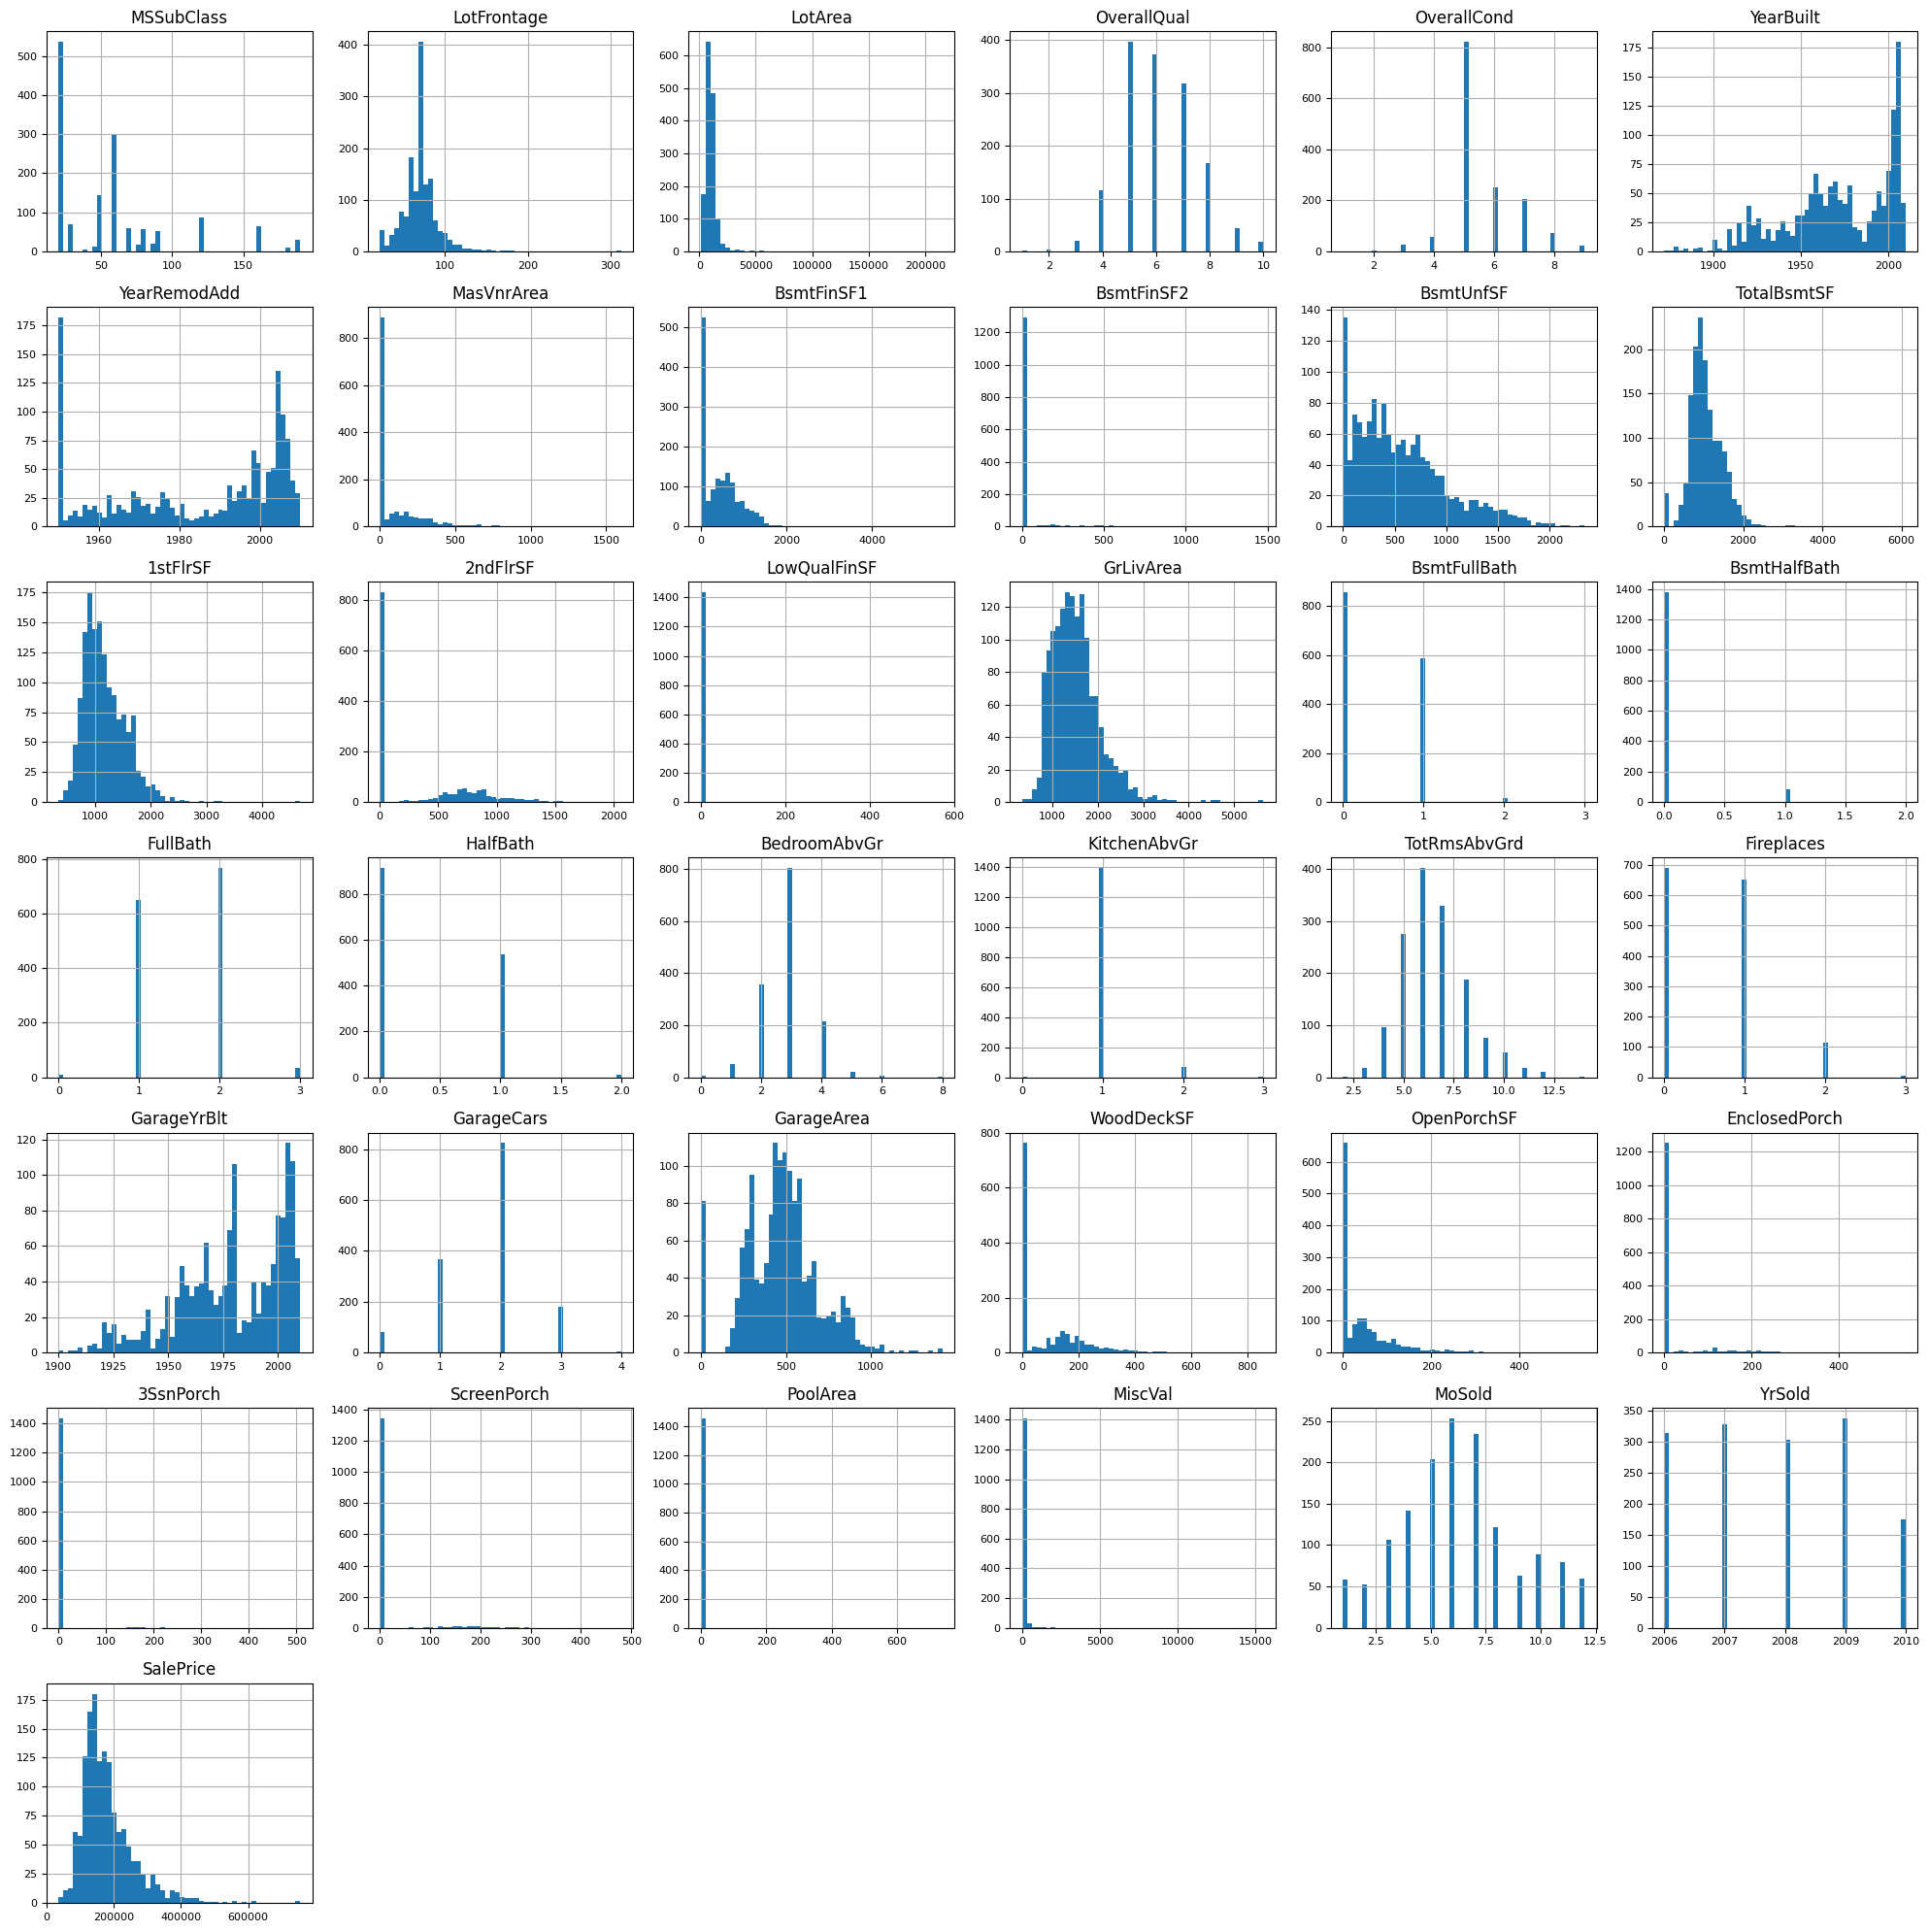

In [16]:
train_df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

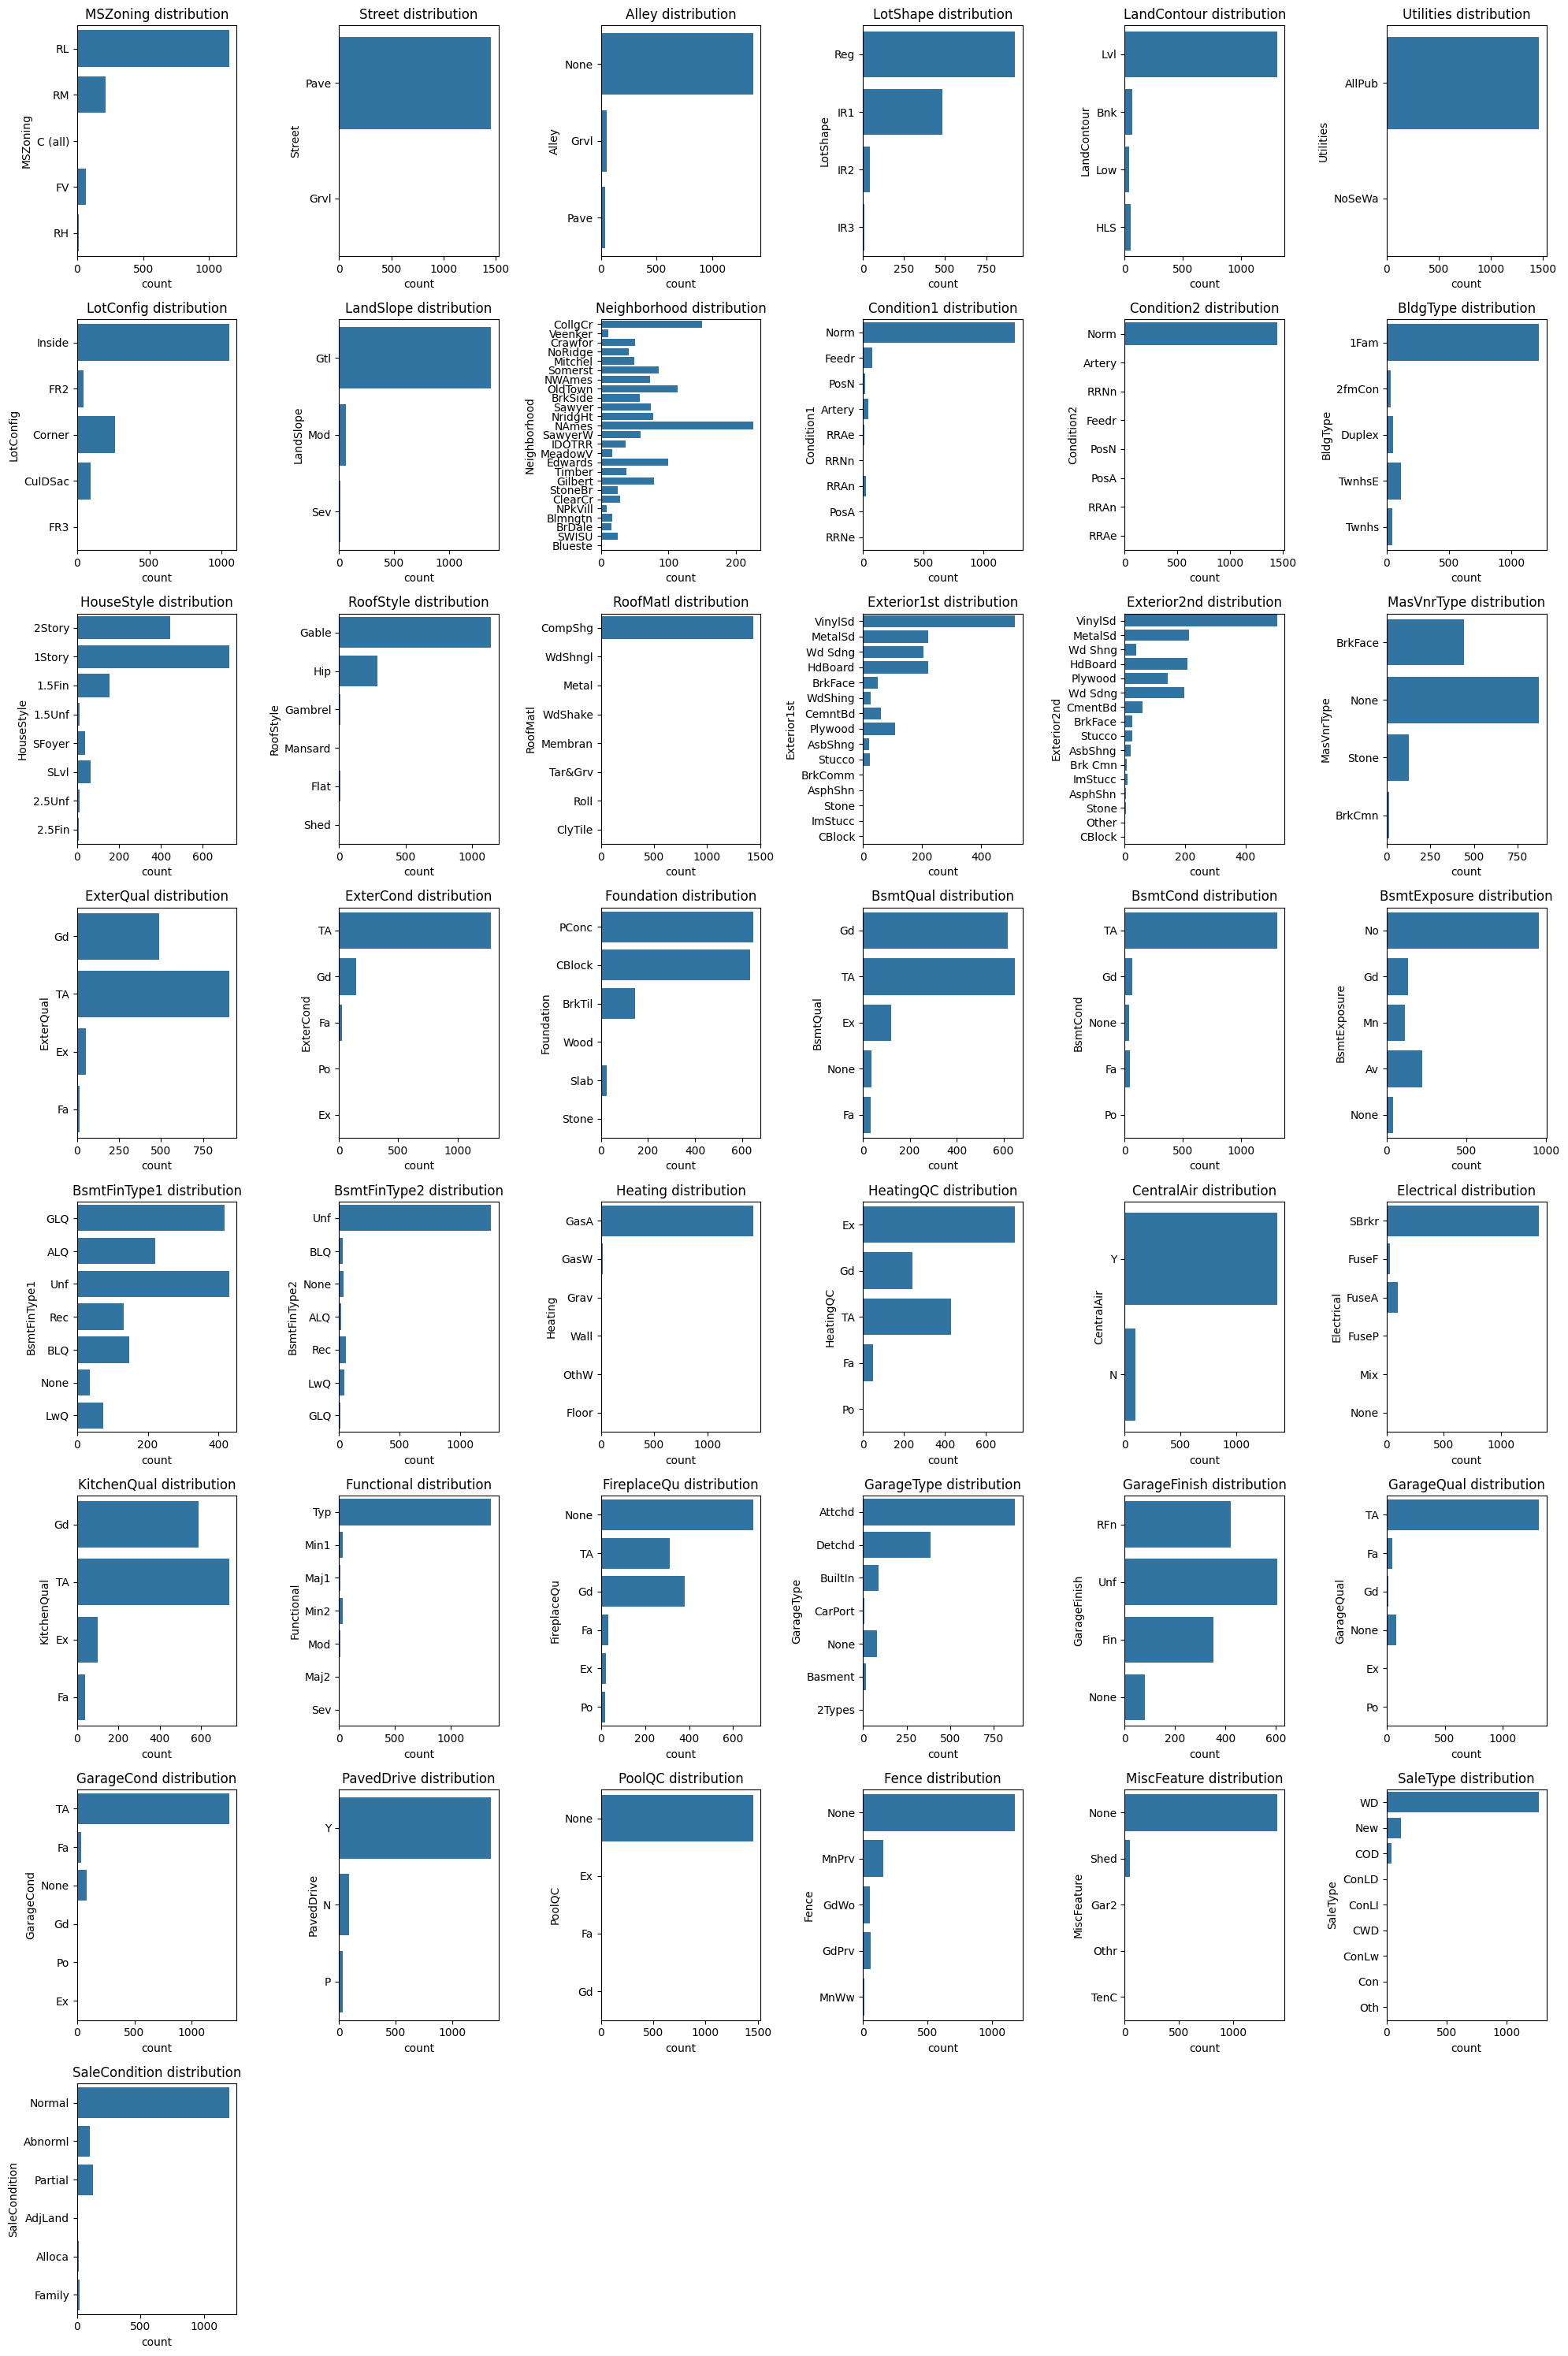

In [17]:
cat_cols = train_df.select_dtypes(include='object').columns.tolist()
data = train_df[cat_cols]

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(20, 30))

# remove any empty plots
for i in range(len(cat_cols), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

for ax, var in zip(axes.flatten(), data.columns):
    sns.countplot(data[var], ax=ax)
    ax.set_title(f'{var} distribution')

plt.tight_layout()
plt.show()


## Distribution of categorical variables in relation to SalePrice

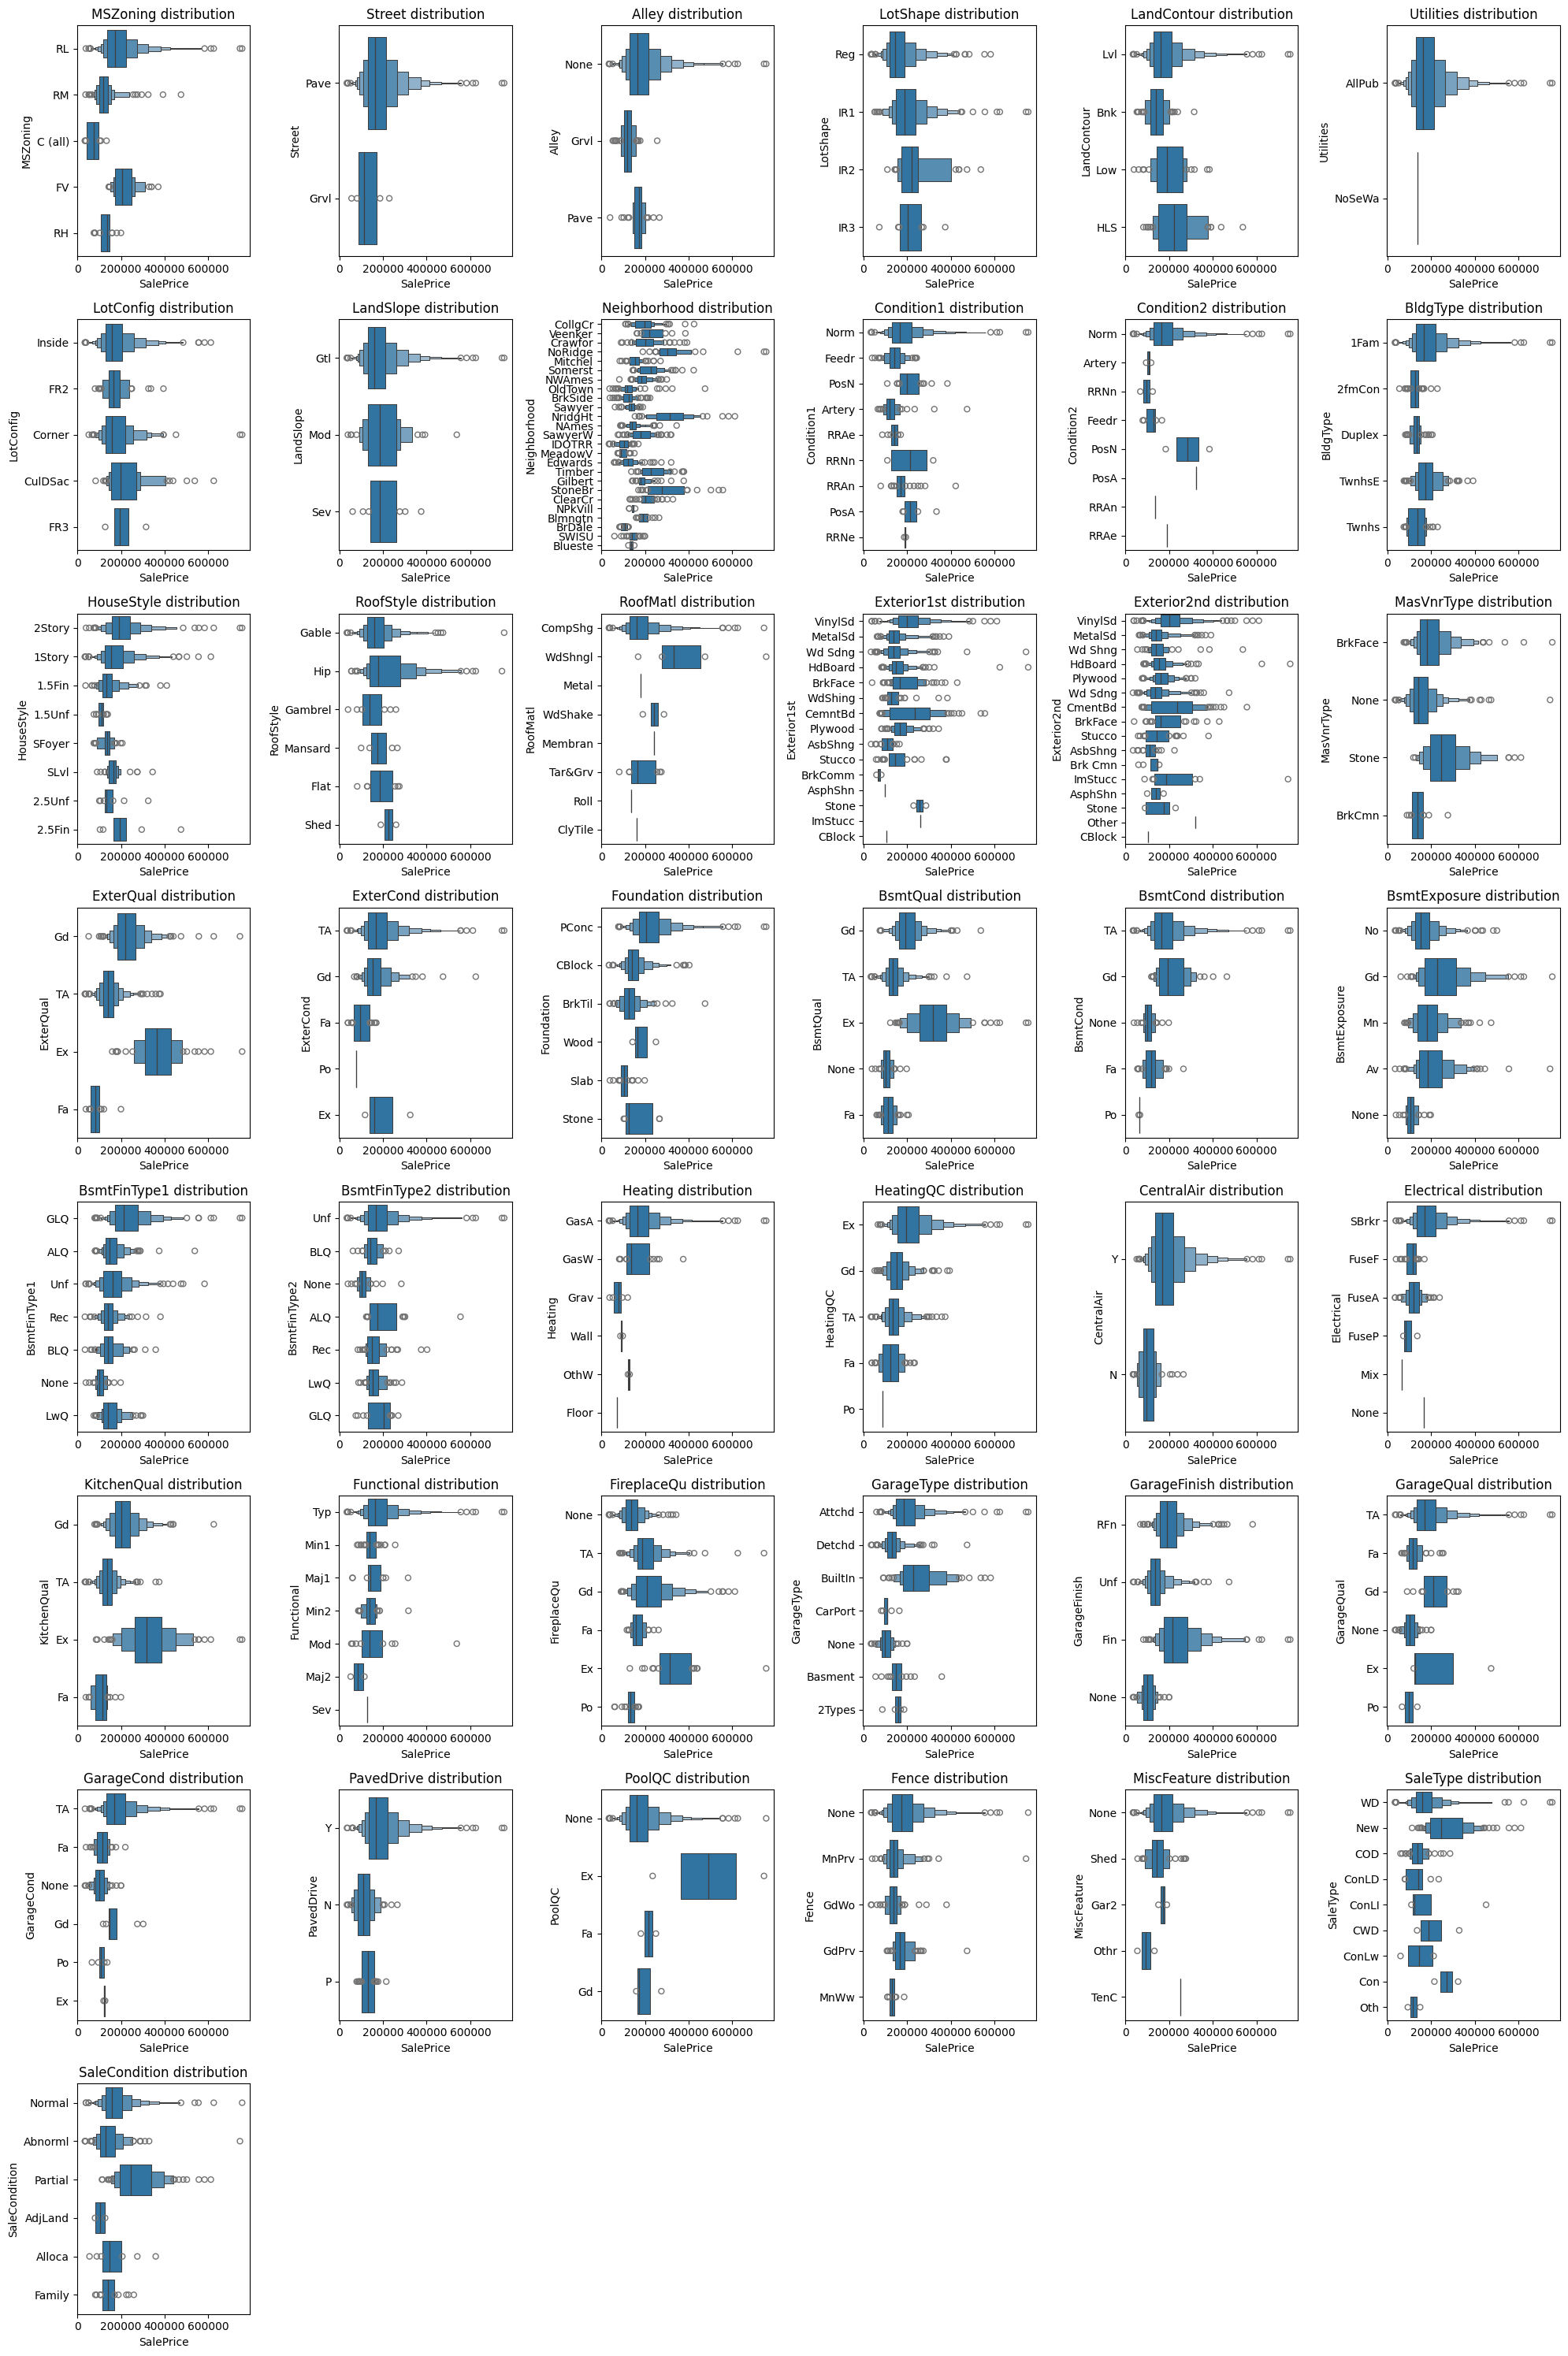

In [36]:
cat_cols_2 = cat_cols + ['SalePrice']
data = train_df[cat_cols_2]

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(20, 30))

# remove any empty plots
for i in range(len(cat_cols), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

for ax, var in zip(axes.flatten(), cat_cols):
    sns.boxenplot(y=data[var], x=data['SalePrice'], ax=ax)
    ax.set_title(f'{var} distribution')
    
plt.tight_layout()
plt.show()

There are a number of categorical variables that offer some explanation in variance of property sale price. For example, the SalePrice distribution of kitchen quality reflects higher property prices for 'Ex' kitchens in comparison with poorer quality type kitchens. A likely explanation for this is home owners with more disposable income can afford to have nicer kitchens whereas a person with less money would have to suffice with the a lower quality kitchen which is a product of buying a property with a lower value. Having a more income results in being able to purchase more expensive properties and hence be able to afford nicer property features.

### Target Variable (SalePrice) Investigation

In [18]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

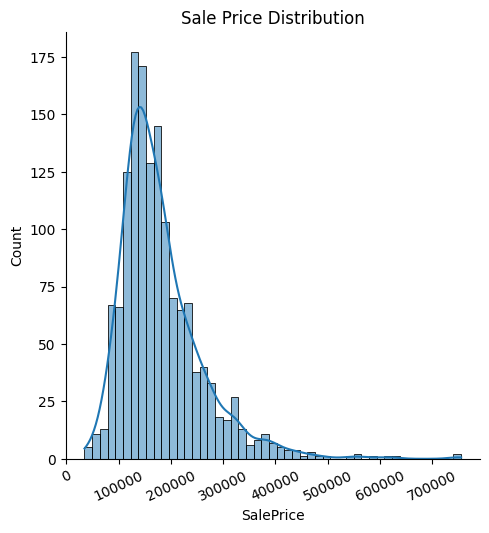

In [19]:
sns.displot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.xticks(rotation=25)
plt.show()

## Check for outliers

In [20]:
df = train_df.select_dtypes(include='number')

# check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
outlier_pct = (outliers / len(df) * 100).round(2)

outlier_df = pd.DataFrame({'outliers': outliers, 'outlier_pct': outlier_pct})
outlier_df.head(20)

,outliers,outlier_pct
EnclosedPorch,208,14.25
BsmtFinSF2,167,11.44
OverallCond,125,8.56
ScreenPorch,116,7.95
LotFrontage,106,7.26
MSSubClass,103,7.05
MasVnrArea,98,6.71
BsmtHalfBath,82,5.62
OpenPorchSF,77,5.27
LotArea,69,4.73


There are some variables with a number of outliers, feature scaling will attempt to solve this - feature scaling will be implemented in our model building pipeline.

## Pairwise Analysis

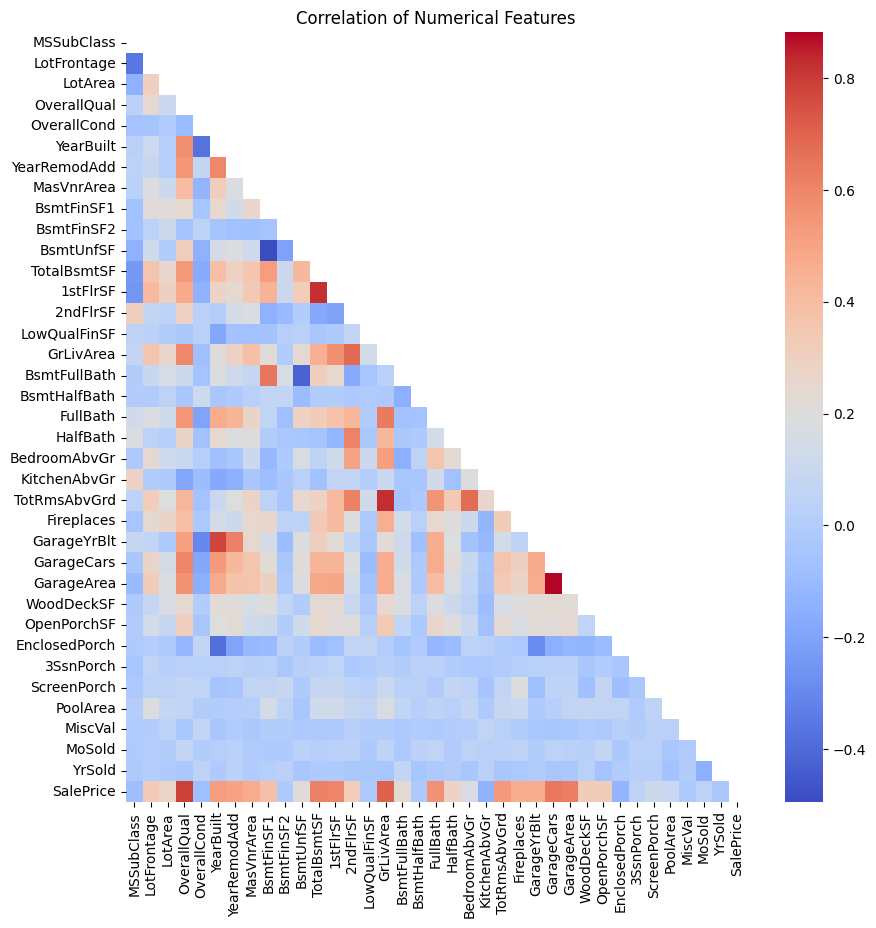

In [21]:
fig = plt.figure(figsize=(10, 10))

corr = train_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm')
plt.title('Correlation of Numerical Features')
plt.show()

Some features are correlated with each other therefore may lead to multicollinearity. To check this further we can use the variance inflation factor to see which variables are highly collinear.

In [23]:
def check_multicollinearity(df: pd.DataFrame) -> pd.DataFrame:
    """Check for multicollinearity using the variance inflation factor (VIF).

    Args:
        df (pd.DataFrame): pandas dataframe

    Returns:
        pd.DataFrame: pandas dataframe with VIF results
    """
    # Ensure that the dataframe contains only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number])
    
    # Drop the target variable
    numeric_columns = numeric_columns.drop("SalePrice", axis=1)

    # Convert the numeric columns to a numpy array
    num_values = numeric_columns.values

    # Calculate VIF
    vif = pd.DataFrame()
    vif["VIF Factor"] = [
        variance_inflation_factor(num_values, i) for i in range(num_values.shape[1])
    ]
    vif["features"] = numeric_columns.columns
    return vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)

In [24]:
check_multicollinearity(train_df)

/Users/conal/Projects/kaggle_comps/house_prices_adv_reg/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,BsmtFinSF2
1,inf,BsmtFinSF1
2,inf,GrLivArea
3,inf,LowQualFinSF
4,inf,2ndFlrSF
5,inf,1stFlrSF
6,inf,TotalBsmtSF
7,inf,BsmtUnfSF
8,2.404984e+04,YrSold
9,2.251703e+04,GarageYrBlt


VIF can be interpreted as a value greater than 5 is showing high multicollinearity - a variable is directly explainable by another.

There are a number of VIF values over 5 which indicates these variables are exhibiting multicollinearity. This makes sense when we look at the names of each variable. For example, 1stFlrSF and 2ndFlrSF are likely be exactly, or nearly exactly, the same given that a second floor essentially mirrors the surface area of the first floor.

We can remove these variables for traditional machine learning approaches such as linear regression or, we can also leave them in and see how they perform using techniques that handle multicollinearity. We could also generate new variables which are able to capture the effects of collinear variables, for example, 1stFlrSF and 2ndFlrSF could be transformed into TotalFlrSF.

Plot relationships between SalePrice and numerical variables

In [26]:
def relationships(
    df: pd.DataFrame,
    y: str,
    X: list[str],
    hue: str = None,
    palette: str = None,
    nrows: int = 4,
    ncols: int = 4,
    figsize: tuple[int, int] = (15, 15),
) -> None:
    """Plots relationships between y and X.

    Args:
        y (str): dependent variable
        X (list[str]): list of independent variables
        hue (str, optional): column to hue by. Defaults to None.
        palette (str, optional): colour palette. Defaults to None.
        nrows (int, optional): plot grid rows. Defaults to 4.
        ncols (int, optional): plot grid columns. Defaults to 4.
    """
    # make sure y is not in X
    X = [col for col in X if col != y]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # remove empty subplots
    for i in range(len(X), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

    for stat, ax in zip(X, axes.flatten()):
        sns.scatterplot(
            data=df,
            x=stat,
            y=y,
            hue=hue,
            palette=palette,
            ax=ax,
            legend=True,
        )
        ax.set_title(f"{y} vs {stat}")
        ax.set_xlabel(stat)
        ax.set_ylabel(y)
        ax.get_legend().remove()
        plt.setp(ax.get_xticklabels(), rotation=15)

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    # set legend
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(1, 1),
        title=hue,
    )


    plt.suptitle(f"{y} vs Related Stats", fontsize=20)
    plt.tight_layout()
    plt.show()

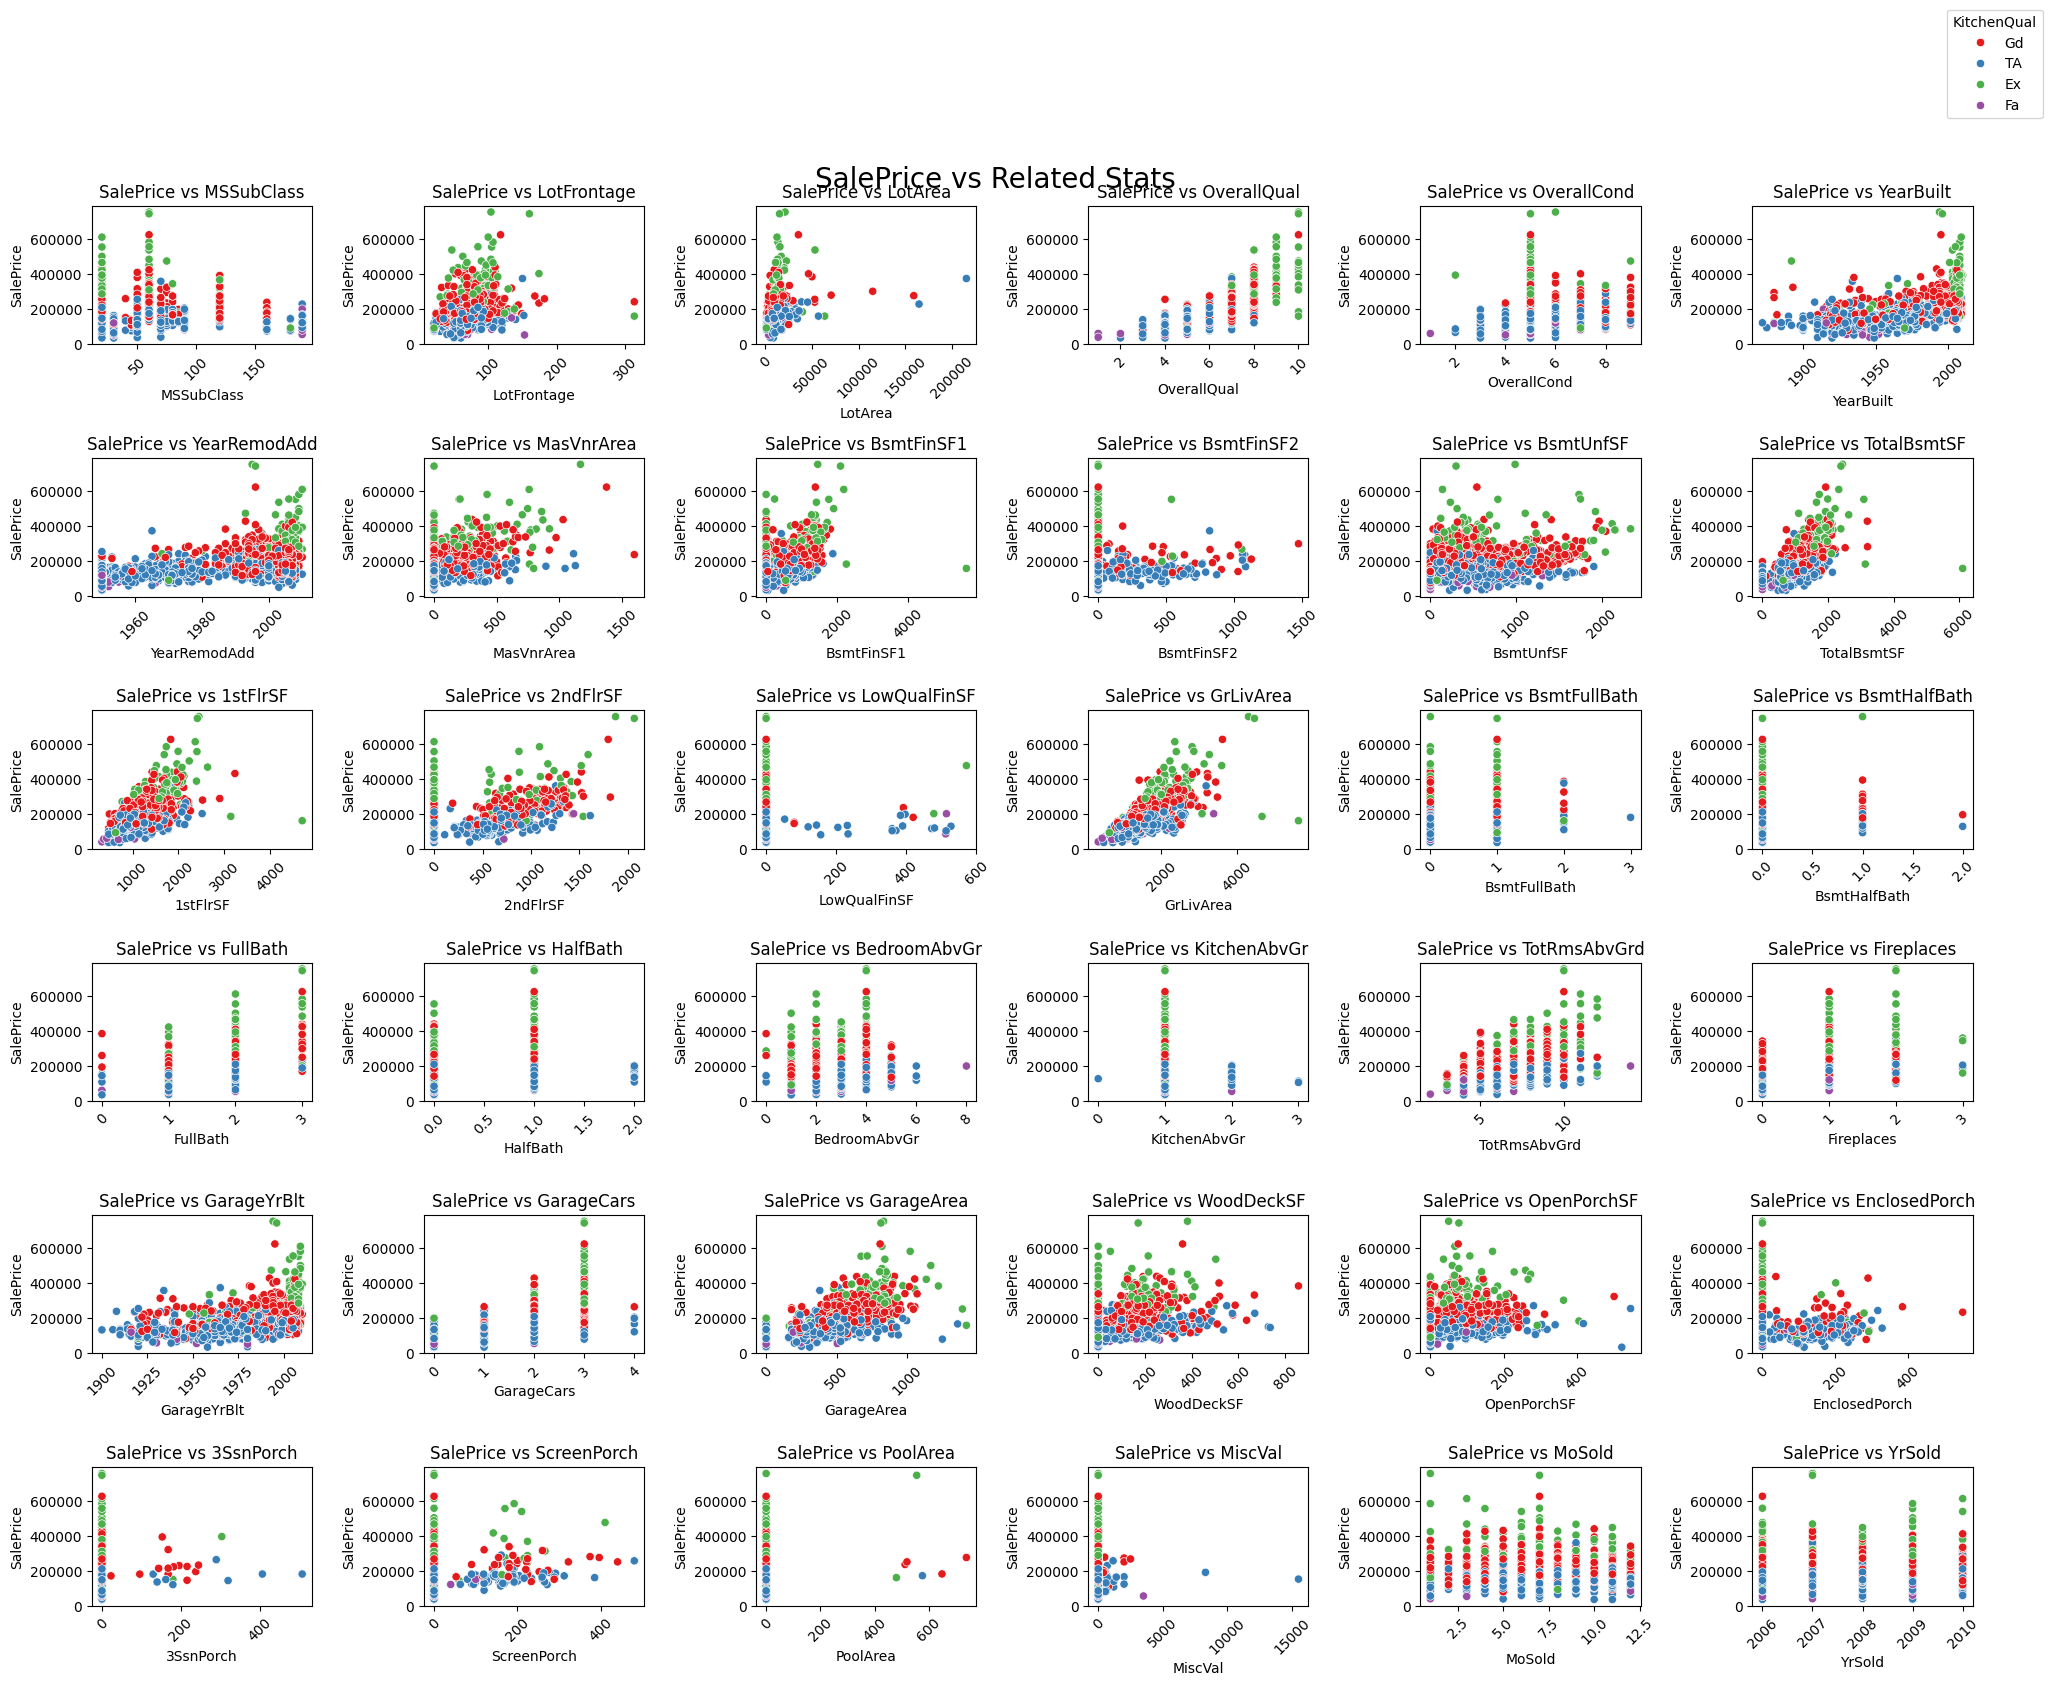

In [27]:
relationships(
    df=train_df,
    y='SalePrice',
    X=train_df.select_dtypes(include='number').columns.tolist(),
    hue='KitchenQual',
    palette='Set1',
    nrows=8,
    ncols=6,
    figsize=(20, 20),
)

When we plot the relationships of each numerical variable and SalePrice hued by Kitchen quality there are some notable trends. For example, when we look at the relationship between SalePrice and GarageYrBlt, we can see that garages built recently (post-2000) tend to also have kitchens of higher quality. This may indicate that these are new build homes hence the building of a new garage while also fitting a new high quality kitchen. This may also reflect wider socio-economic issues faced in the 21st century where housing has become less and less affordable because of the lack of affordable housing being built leading to problems such as homelessness.  

Correlations of numeric variables with SalePrice

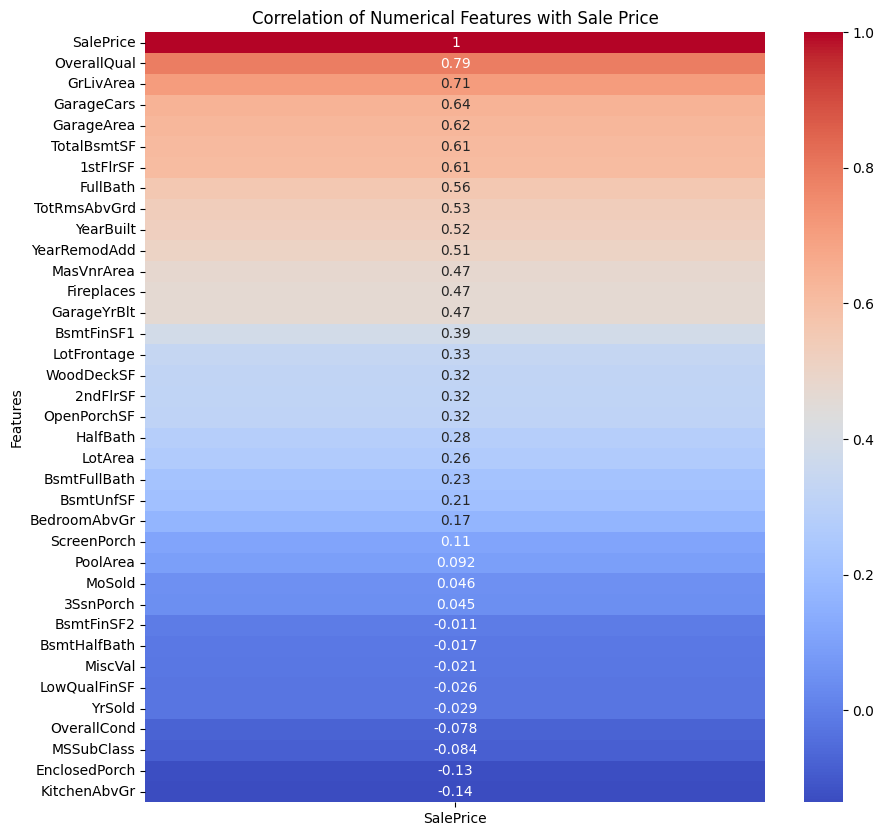

In [28]:
fig = plt.figure(figsize=(10, 10))
y_cors = train_df.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending=False)
sns.heatmap(y_cors, annot=True, cmap='coolwarm')
plt.title('Correlation of Numerical Features with Sale Price')
plt.ylabel('Features')
plt.show()